Data cleaning & merging

In [1]:
# -----------------------------------------------------------
# Import all required Python libraries
# pandas → data manipulation
# numpy  → numeric operations
# -----------------------------------------------------------

import pandas as pd
import numpy as np


In [2]:
# -----------------------------------------------------------
# Load your CSV file from the /content/ folder in Colab.
# Make sure your uploaded filename matches exactly.
# -----------------------------------------------------------

file_path = "U.S._Chronic_Disease_Indicators.csv"

df = pd.read_csv(file_path)

# Show the shape (#rows, #columns)
print(df.shape)

# Display first few rows to inspect structure
df.head()


(309215, 34)


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN


In [3]:
# -----------------------------------------------------------
# Calculate the fraction (%) of missing values per column.
# Sorting helps us quickly see which columns are problematic.
# -----------------------------------------------------------

missing_summary = df.isna().mean().sort_values(ascending=False)

# Show top 20 columns with highest missingness
missing_summary.head(20)


,0
StratificationCategoryID3,1.000000
Response,1.000000
ResponseID,1.000000
StratificationCategory2,1.000000
StratificationID2,1.000000
StratificationCategoryID2,1.000000
Stratification3,1.000000
StratificationCategory3,1.000000
Stratification2,1.000000
StratificationID3,1.000000


In [4]:
# -----------------------------------------------------------
# Identify columns with 100% missing values (completely empty).
# These add no value and can be safely removed.
# -----------------------------------------------------------

cols_all_missing = missing_summary[missing_summary == 1.0].index.tolist()
cols_all_missing


['StratificationCategoryID3',
 'Response',
 'ResponseID',
 'StratificationCategory2',
 'StratificationID2',
 'StratificationCategoryID2',
 'Stratification3',
 'StratificationCategory3',
 'Stratification2',
 'StratificationID3']

In [5]:
# -----------------------------------------------------------
# Drop the fully-empty columns from the dataset.
# -----------------------------------------------------------

df_clean = df.drop(columns=cols_all_missing)

print("Shape after dropping empty columns:", df_clean.shape)


Shape after dropping empty columns: (309215, 24)


In [6]:
# -----------------------------------------------------------
# CELL 5: Clean invalid/missing DataValue rows
# Then fill confidence limits and geolocation
# Drop footnote columns *only if they exist*
# -----------------------------------------------------------

before = len(df_clean)

# Remove rows with missing DataValue
df_clean = df_clean[~df_clean["DataValue"].isna()]

# Remove infinite values
df_clean = df_clean[np.isfinite(df_clean["DataValue"])]

after = len(df_clean)

print(f"Rows before cleaning DataValue: {before}")
print(f"Rows after cleaning DataValue:  {after}")


# ---------- SAFE DROP footnote columns ----------
cols_to_drop = ['DataValueFootnoteSymbol', 'DataValueFootnote']
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])

print("Shape after dropping footnote columns (if present):", df_clean.shape)


# ---------- Fill confidence limit missing values ----------
if 'LowConfidenceLimit' in df_clean.columns:
    df_clean['LowConfidenceLimit'] = df_clean['LowConfidenceLimit'].fillna(
        df_clean['LowConfidenceLimit'].median()
    )

if 'HighConfidenceLimit' in df_clean.columns:
    df_clean['HighConfidenceLimit'] = df_clean['HighConfidenceLimit'].fillna(
        df_clean['HighConfidenceLimit'].median()
    )


# ---------- Fill missing geolocation ----------
if 'Geolocation' in df_clean.columns:
    df_clean['Geolocation'] = df_clean['Geolocation'].fillna("Unknown")

print("Finished filling missing confidence limits + geolocation.")


Rows before cleaning DataValue: 309215
Rows after cleaning DataValue:  209196
Shape after dropping footnote columns (if present): (209196, 22)
Finished filling missing confidence limits + geolocation.


In [7]:
# -----------------------------------------------------------
# CELL 6: Create clean Year column and rename state fields
# -----------------------------------------------------------

# Create Year from YearStart
df_clean["Year"] = df_clean["YearStart"].astype(int)

# Rename for consistency
df_clean.rename(
    columns={
        "LocationAbbr": "State",
        "LocationDesc": "StateName"
    },
    inplace=True
)

df_clean[["State", "StateName", "Year"]].head()


,State,StateName,Year
0,US,United States,2020
1,AR,Arkansas,2015
2,CA,California,2015
3,CO,Colorado,2015
4,GA,Georgia,2015


In [8]:
# -----------------------------------------------------------
# DATA CLEANING BLOCK (3 FIXES APPLIED TOGETHER)
# -----------------------------------------------------------

# 1️⃣ Convert DataValue to numeric & remove impossible percentage values
df_clean = df.copy()
df_clean["DataValue"] = pd.to_numeric(df_clean["DataValue"], errors="coerce")

# Keep only values between 0 and 100 → valid percentage range
df_clean = df_clean[(df_clean["DataValue"] >= 0) & (df_clean["DataValue"] <= 100)]
print("✔ After Fix-1: Rows remaining with valid percentage range:", df_clean.shape[0])

# -----------------------------------------------------------

# 2️⃣ Remove non-state rows like US, PR, GU, VI, AS, MP etc.
valid_states = [
    "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS",
    "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY",
    "NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV",
    "WI","WY","DC"
]

df_states_only = df_clean[df_clean["LocationAbbr"].isin(valid_states)]
print("✔ After Fix-2: rows left with only U.S. states:", df_states_only.shape[0])

# -----------------------------------------------------------

# 3️⃣ Keep ONLY percentage-based indicators (remove hospital counts, incidence counts)
valid_types = ["Crude Prevalence", "Age-adjusted Prevalence",
               "Crude Percentage", "Age-adjusted Percentage"]

df_final = df_states_only[df_states_only["DataValueType"].isin(valid_types)]
print("✔ After Fix-3: rows with ONLY percentage prevalence indicators:", df_final.shape[0])

# -----------------------------------------------------------
print("\n🎉 Final Clean Dataset Ready for EDA + Modeling: df_final")
df_final.head()

✔ After Fix-1: Rows remaining with valid percentage range: 183843
✔ After Fix-2: rows left with only U.S. states: 174786
✔ After Fix-3: rows with ONLY percentage prevalence indicators: 127996

🎉 Final Clean Dataset Ready for EDA + Modeling: df_final


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
51,2018,2019,AL,Alabama,NSCH,Sleep,Short sleep duration among children aged 4 mon...,NaN,%,Crude Prevalence,...,SLEP,SLP01,NaN,CRDPREV,SEX,SEXF,NaN,NaN,NaN,NaN
52,2020,2020,KY,Kentucky,BRFSS,Immunization,Influenza vaccination among adults,NaN,%,Crude Prevalence,...,IMM,IMM01,NaN,CRDPREV,RACE,BLK,NaN,NaN,NaN,NaN
53,2018,2019,ID,Idaho,NSCH,Sleep,Short sleep duration among children aged 4 mon...,NaN,%,Crude Prevalence,...,SLEP,SLP01,NaN,CRDPREV,SEX,SEXM,NaN,NaN,NaN,NaN
54,2018,2019,KS,Kansas,NSCH,Sleep,Short sleep duration among children aged 4 mon...,NaN,%,Crude Prevalence,...,SLEP,SLP01,NaN,CRDPREV,SEX,SEXM,NaN,NaN,NaN,NaN
55,2018,2019,MD,Maryland,NSCH,Sleep,Short sleep duration among children aged 4 mon...,NaN,%,Crude Prevalence,...,SLEP,SLP01,NaN,CRDPREV,SEX,SEXF,NaN,NaN,NaN,NaN


In [9]:
# -----------------------------------------------------------
# CELL 7: Create a tidy long-format dataset
# Each row = one indicator for one state/year
# -----------------------------------------------------------

core_cols = [
    "State", "StateName", "Year",
    "Topic", "Question", "DataValue",
    "DataValueUnit", "DataValueType", "DataValueAlt",
    "LowConfidenceLimit", "HighConfidenceLimit",
    "LocationID", "Geolocation"
]

# Only keep columns that actually exist
core_cols = [c for c in core_cols if c in df_clean.columns]

df_long = df_clean[core_cols].copy()

print("Long-format table shape:", df_long.shape)
df_long.head()


Long-format table shape: (183843, 10)


,Topic,Question,DataValue,DataValueUnit,DataValueType,DataValueAlt,LowConfidenceLimit,HighConfidenceLimit,LocationID,Geolocation
0,Health Status,Recent activity limitation among adults,2.9,Number,Age-adjusted Mean,2.9,2.8,2.9,59,NaN
10,Cancer,"Prostate cancer mortality among all males, und...",20.2,"per 100,000",Crude Rate,20.2,18.4,22.2,46,POINT (-100.3735306369997 44.353130053000484)
11,Cancer,"Cervical cancer mortality among all females, u...",2.9,"per 100,000",Crude Rate,2.9,2.8,3.0,48,POINT (-99.42677020599967 31.827240407000488)
13,Cancer,"Prostate cancer mortality among all males, und...",23.0,"per 100,000",Crude Rate,23.0,20.7,25.5,50,POINT (-72.51764079099962 43.62538123900049)
14,Cancer,"Breast cancer mortality among all females, und...",31.6,"per 100,000",Crude Rate,31.6,30.0,33.2,54,POINT (-80.71264013499967 38.66551020200046)


In [10]:
# -----------------------------------------------------------
# CELL 8: Create a wide-format pivot table
# Each indicator becomes a separate column
# You can add/remove indicators in 'selected_questions'
# -----------------------------------------------------------

selected_questions = [
    "Current smoking among adults",
    "Obesity among adults (BMI ≥ 30 kg/m²)",
    "Diabetes among adults",
    "Coronary heart disease among adults",
]

df_selected = df_clean[df_clean["Question"].isin(selected_questions)].copy()

wide_table = df_selected.pivot_table(
    index=["LocationAbbr", "LocationDesc", "YearStart"],
    columns="Question",
    values="DataValue",
    aggfunc="mean"
).reset_index()

print("Wide-format table shape:", wide_table.shape)
wide_table.head()

Wide-format table shape: (217, 4)


Question,LocationAbbr,LocationDesc,YearStart,Diabetes among adults
0,AK,Alaska,2019,8.090909
1,AK,Alaska,2020,9.525000
2,AK,Alaska,2021,10.177778
3,AK,Alaska,2022,10.095238
4,AL,Alabama,2019,14.225000


In [11]:
# -----------------------------------------------------------
# CELL 9: Save cleaned long + wide tables to disk
# -----------------------------------------------------------

df_long.to_csv("cdi_clean_long.csv", index=False)
wide_table.to_csv("cdi_clean_wide.csv", index=False)

print("Saved files successfully:")
print(" - cdi_clean_long.csv")
print(" - cdi_clean_wide.csv")


Saved files successfully:
 - cdi_clean_long.csv
 - cdi_clean_wide.csv


3. Exploratory analysis & indicator selection

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
# Make sure DataValue is numeric
df["DataValue"] = pd.to_numeric(df["DataValue"], errors="coerce")

# Keep only rows with a valid DataValue
df_num = df.dropna(subset=["DataValue"]).copy()

print("Shape after numeric filter:", df_num.shape)
print("\nYears available:", sorted(df_num["YearStart"].unique()))
print("\nStates (LocationAbbr) count:", df_num["LocationAbbr"].nunique())
print("Topics:", df_num["Topic"].nunique())

Shape after numeric filter: (209196, 34)

Years available: [np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]

States (LocationAbbr) count: 55
Topics: 19


In [14]:
#Summary Statistics

# Overall distribution of DataValue
print("Overall DataValue summary:\n")
display(df_num["DataValue"].describe())

# Topic-level summary statistics
topic_summary = (
    df_num
    .groupby("Topic")["DataValue"]
    .agg(["count", "mean", "std", "min", "max"])
    .sort_values("count", ascending=False)
)

print("\nTopic-level summary (top 15 by count):")
display(topic_summary.head(15))

Overall DataValue summary:



,DataValue
count,2.091960e+05
mean,6.943569e+02
std,1.620341e+04
min,0.000000e+00
25%,1.240000e+01
50%,2.700000e+01
75%,5.780000e+01
max,2.925456e+06



Topic-level summary (top 15 by count):


,count,mean,std,min,max
Topic,,,,,
Cardiovascular Disease,23393,1860.673527,19614.445182,0.6,805708.0
"Nutrition, Physical Activity, and Weight Status",19618,26.504465,12.259243,0.0,73.9
Health Status,19157,12.278650,11.870669,0.0,83.9
Chronic Obstructive Pulmonary Disease,18337,3084.580554,44315.300665,0.0,2925456.0
Cancer,16499,1858.512419,22837.865220,0.7,901250.0
Alcohol,16398,84.916572,1108.874775,0.0,56585.0
Social Determinants of Health,12307,44.620257,34.027228,0.0,100.0
Immunization,12242,44.907401,15.424056,6.8,85.6
Arthritis,11960,31.859992,18.494868,0.0,92.3


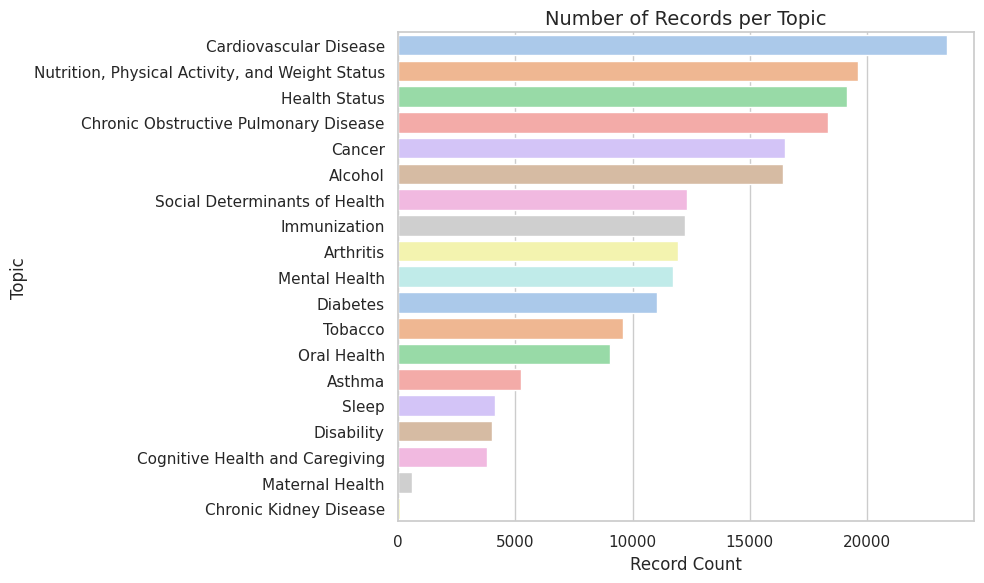

In [15]:
#Plot: Records per Topic
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

topic_counts = df_num["Topic"].value_counts()

# pastel palette sized exactly to number of topics
palette = sns.color_palette("pastel", len(topic_counts))

plt.figure(figsize=(10, 6))

sns.barplot(
    y=topic_counts.index,
    x=topic_counts.values,
    hue=topic_counts.index,    # required to avoid future warning
    palette=palette,
    dodge=False,
    legend=False               # hide legend because y already shows names
)

plt.title("Number of Records per Topic", fontsize=14)
plt.xlabel("Record Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


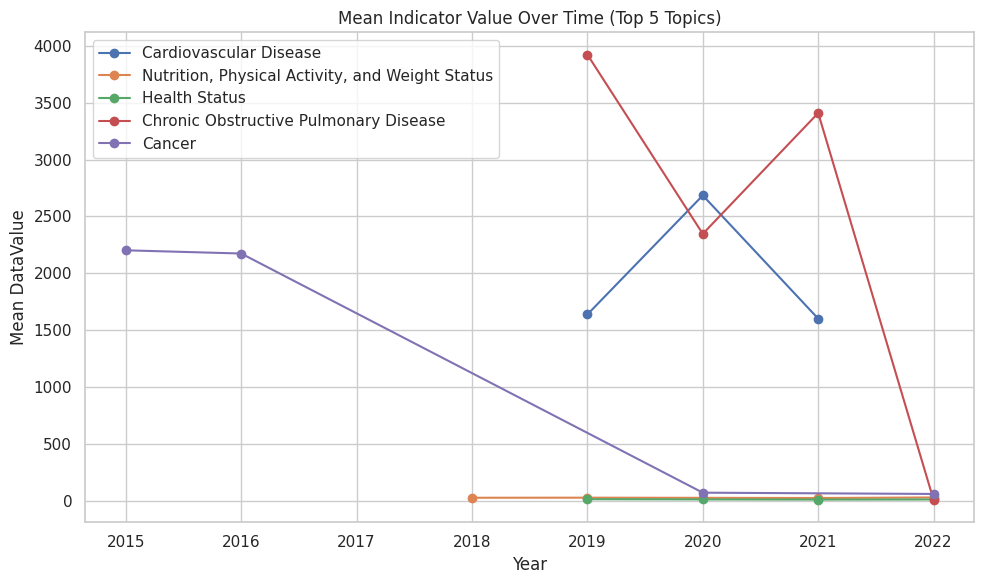

In [16]:
#Plot: Time Trends for Top Topics
# Group by year and topic
topic_year = (
    df_num.groupby(["YearStart", "Topic"])["DataValue"]
          .mean()
          .reset_index()
)

# select top 5 topics based on record count
top_topics = topic_counts.index[:5]

plt.figure(figsize=(10, 6))
for t in top_topics:
    sub = topic_year[topic_year["Topic"] == t]
    plt.plot(sub["YearStart"], sub["DataValue"], marker="o", label=t)

plt.title("Mean Indicator Value Over Time (Top 5 Topics)")
plt.xlabel("Year")
plt.ylabel("Mean DataValue")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
#Indicator-Level Statistics (Questions)
indicator_stats = (
    df_num.groupby(["Topic", "Question"])
          .agg(
              n_rows=("DataValue", "size"),
              n_states=("LocationAbbr", "nunique"),
              n_years=("YearStart", "nunique"),
              mean_value=("DataValue", "mean")
          )
          .reset_index()
          .sort_values(["n_states", "n_years", "n_rows"], ascending=False)
)

print("Top 20 Indicators (Coverage):")
display(indicator_stats.head(20))


Top 20 Indicators (Coverage):


,Topic,Question,n_rows,n_states,n_years,mean_value
56,Immunization,Influenza vaccination among adults,4107,55,4,43.506063
76,"Nutrition, Physical Activity, and Weight Status",No leisure-time physical activity among adults,4033,55,4,25.251475
49,Disability,Adults with any disability,4029,55,4,30.014520
78,"Nutrition, Physical Activity, and Weight Status",Obesity among adults,3973,55,4,33.688195
51,Health Status,Average recent physically unhealthy days among...,3919,55,4,3.934907
63,Mental Health,Depression among adults,3870,55,4,20.859742
99,Social Determinants of Health,Routine checkup within the past year among adults,3837,55,4,74.487386
55,Health Status,Recent activity limitation among adults,3836,55,4,3.003858
52,Health Status,Fair or poor self-rated health status among ad...,3796,55,4,18.333614
64,Mental Health,Frequent mental distress among adults,3764,55,4,15.704091


In [18]:
#Identify Chronic-Disease vs Risk-Factor Indicators
chronic_topics = [
    "Cardiovascular Disease", "Diabetes", "Cancer",
    "Chronic Obstructive Pulmonary Disease",
    "Chronic Kidney Disease", "Asthma"
]

risk_topics = [
    "Tobacco", "Alcohol",
    "Nutrition, Physical Activity, and Weight Status",
    "Social Determinants of Health"
]

chronic_indicators = indicator_stats[indicator_stats["Topic"].isin(chronic_topics)]
risk_indicators = indicator_stats[indicator_stats["Topic"].isin(risk_topics)]

print("Chronic Indicators (Top 15):")
display(chronic_indicators.head(15))

print("\nRisk-Factor Indicators (Top 15):")
display(risk_indicators.head(15))


Chronic Indicators (Top 15):


,Topic,Question,n_rows,n_states,n_years,mean_value
45,Diabetes,Diabetes among adults,3540,55,4,12.205706
15,Asthma,Current asthma among adults,3341,55,4,11.314397
35,Chronic Obstructive Pulmonary Disease,Chronic obstructive pulmonary disease among ad...,3141,55,4,7.074944
32,Cardiovascular Disease,Taking medicine for high cholesterol among adults,1965,55,2,31.741527
30,Cardiovascular Disease,High cholesterol among adults who have been sc...,1963,55,2,32.019562
29,Cardiovascular Disease,High blood pressure among adults,1916,55,2,40.415605
33,Cardiovascular Disease,Taking medicine to control high blood pressure...,1665,55,2,67.549309
20,Cancer,Colorectal cancer screening among adults aged ...,1489,55,2,58.243318
24,Cancer,Mammography use among women aged 50-74 years,628,55,2,76.115446
38,Chronic Obstructive Pulmonary Disease,Current smoking among adults with chronic obst...,1830,54,3,37.258306



Risk-Factor Indicators (Top 15):


,Topic,Question,n_rows,n_states,n_years,mean_value
76,"Nutrition, Physical Activity, and Weight Status",No leisure-time physical activity among adults,4033,55,4,25.251475
78,"Nutrition, Physical Activity, and Weight Status",Obesity among adults,3973,55,4,33.688195
99,Social Determinants of Health,Routine checkup within the past year among adults,3837,55,4,74.487386
103,Tobacco,Current cigarette smoking among adults,3738,55,4,16.723756
3,Alcohol,Binge drinking prevalence among adults,3644,55,4,16.509468
2,Alcohol,Binge drinking intensity among adults who bing...,3462,55,4,6.458232
1,Alcohol,Binge drinking frequency among adults who bing...,3273,55,4,3.122579
94,Social Determinants of Health,Lack of health insurance among adults aged 18-...,2858,55,4,14.084045
107,Tobacco,Proportion of the population protected by a co...,163,55,3,32.328712
67,"Nutrition, Physical Activity, and Weight Status",Consumed fruit less than one time daily among ...,2033,55,2,40.187457


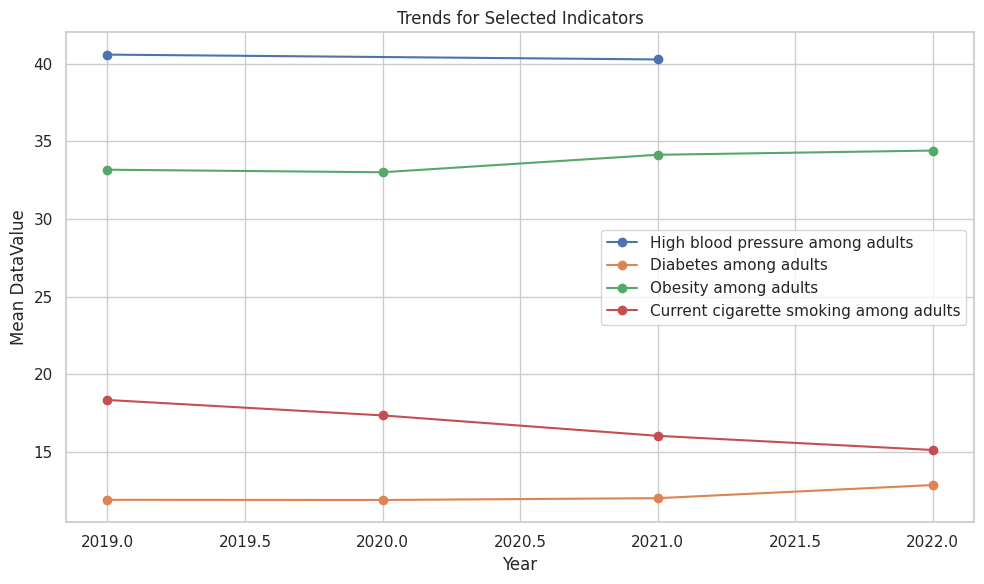

In [19]:
#Visualize Example Candidate Indicators
candidate_questions = [
    "High blood pressure among adults",
    "Diabetes among adults",
    "Obesity among adults",
    "Current cigarette smoking among adults"
]

plt.figure(figsize=(10, 6))
for q in candidate_questions:
    sub = (
        df_num[df_num["Question"] == q]
        .groupby("YearStart")["DataValue"]
        .mean()
        .reset_index()
    )

    if not sub.empty:
        plt.plot(sub["YearStart"], sub["DataValue"], marker="o", label=q)

plt.title("Trends for Selected Indicators")
plt.xlabel("Year")
plt.ylabel("Mean DataValue")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Final Indicator Selection
KEY_CHRONIC_INDICATORS = [
    "High blood pressure among adults",
    "Diabetes among adults"
]

KEY_RISK_INDICATORS = [
    "Obesity among adults",
    "Current cigarette smoking among adults"
]

print("Selected indicators for project:")
print(KEY_CHRONIC_INDICATORS)
print(KEY_RISK_INDICATORS)


Selected indicators for project:
['High blood pressure among adults', 'Diabetes among adults']
['Obesity among adults', 'Current cigarette smoking among adults']


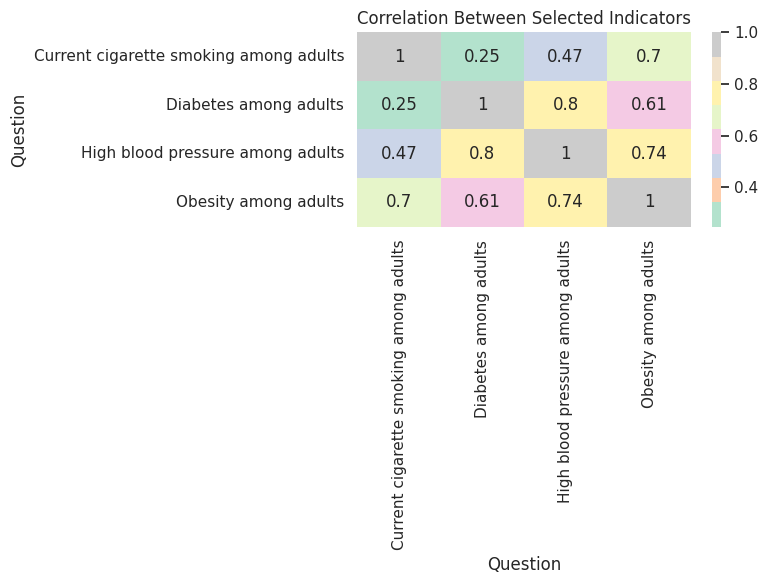

In [21]:
# Correlation heatmap for selected indicators

df_corr = (
    df_num[df_num["Question"].isin(KEY_CHRONIC_INDICATORS + KEY_RISK_INDICATORS)]
    .groupby(["LocationAbbr", "Question"])["DataValue"]
    .mean()
    .unstack()
)

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap="Pastel2")
plt.title("Correlation Between Selected Indicators")
plt.tight_layout()
plt.show()


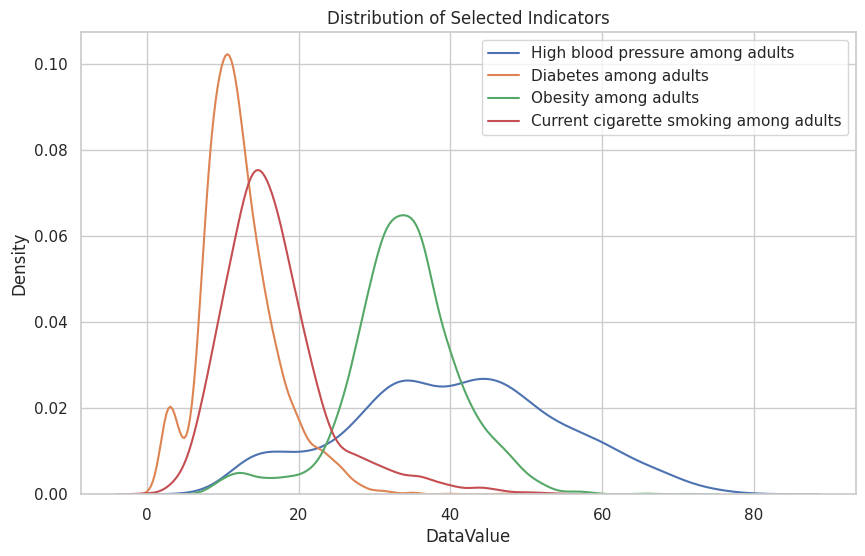

In [22]:
plt.figure(figsize=(10, 6))
for q in KEY_CHRONIC_INDICATORS + KEY_RISK_INDICATORS:
    sns.kdeplot(df_num[df_num["Question"] == q]["DataValue"], label=q)

plt.title("Distribution of Selected Indicators")
plt.xlabel("DataValue")
plt.ylabel("Density")
plt.legend()
plt.show()


In [23]:
import plotly.express as px

indicator_keyword = "Obesity"

df_map = df[df["Question"].str.contains(indicator_keyword, case=False, na=False)]
year_to_plot = df_map["YearStart"].max()
df_map_year = df_map[df_map["YearStart"] == year_to_plot]
df_map_year = df_map_year[df_map_year["LocationAbbr"] != "US"]

fig = px.choropleth(
    df_map_year,
    locations="LocationAbbr",
    locationmode="USA-states",
    color="DataValue",
    hover_name="LocationDesc",
    hover_data={"LocationAbbr": True, "DataValue": True},
    title=f"{indicator_keyword} by U.S. State ({year_to_plot})",
    color_continuous_scale="Reds",
    scope="usa"
)

# ---- Add state abbreviation labels ----
fig.add_scattergeo(
    locations=df_map_year["LocationAbbr"],
    locationmode="USA-states",
    text=df_map_year["LocationAbbr"],
    mode="text",
    textfont=dict(color="black", size=10, family="Arial"),
    hoverinfo="skip"
)

# Optional: clean layout
fig.update_layout(
    margin=dict(l=0, r=0, t=40, b=0),
    title=dict(x=0.5, font=dict(size=22))
)

fig.show()

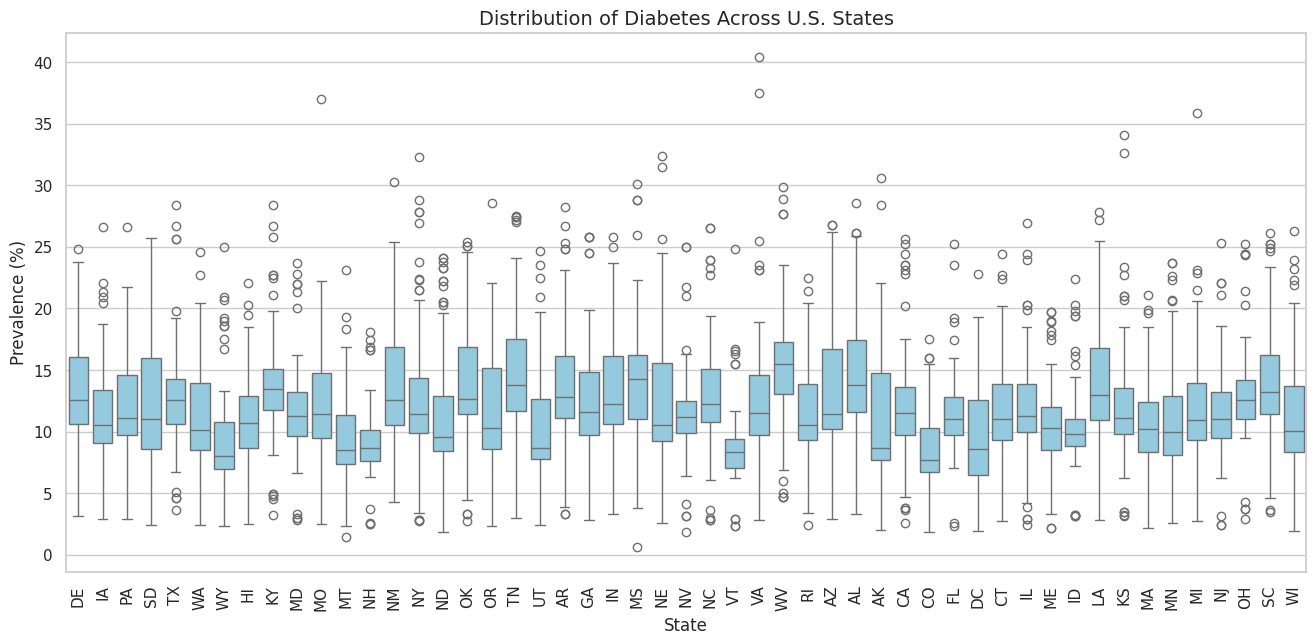

In [24]:
# -----------------------------------------------------------
# 📊 BOX PLOT – Distribution of a Health Indicator Across States
# Example indicator used: Diabetes
# -----------------------------------------------------------

indicator_keyword = "Diabetes"   # You can change to Smoking / Obesity / etc.

# Filter final cleaned dataset for the selected indicator
df_plot = df_final[df_final["Question"].str.contains(indicator_keyword, case=False, na=False)]

plt.figure(figsize=(16, 7))  # Wide plot so state labels don’t overlap

# Draw boxplot: Each state on X-axis, % prevalence on Y-axis
sns.boxplot(data=df_plot, x="LocationAbbr", y="DataValue", color="skyblue")

# Rotate state names to make them readable
plt.xticks(rotation=90)

# Titles & axis labels
plt.title(f"Distribution of {indicator_keyword} Across U.S. States", fontsize=14)
plt.xlabel("State")
plt.ylabel("Prevalence (%)")

# Display chart
plt.show()

#Baseline modelling

In [25]:
# ============================================================
# RQ1 – Data prep: build state–year table for 3 indicators
#   Indicators:
#     - Obesity among adults
#     - Current cigarette smoking among adults
#     - Diabetes among adults
# ============================================================

import pandas as pd
import numpy as np

# Use df_num from previous steps (numeric DataValue, cleaned)
selected_questions_rq1 = [
    "Obesity among adults",
    "Current cigarette smoking among adults",
    "Diabetes among adults"
]

df_base_rq1 = df_num[df_num["Question"].isin(selected_questions_rq1)].copy()

wide_rq1 = df_base_rq1.pivot_table(
    index=["LocationAbbr", "YearStart"],
    columns="Question",
    values="DataValue",
    aggfunc="mean"
).reset_index()

print("Wide RQ1 table shape:", wide_rq1.shape)
wide_rq1.head()


Wide RQ1 table shape: (217, 5)


Question,LocationAbbr,YearStart,Current cigarette smoking among adults,Diabetes among adults,Obesity among adults
0,AK,2019,20.433333,8.090909,32.394118
1,AK,2020,19.893750,9.525000,31.894737
2,AK,2021,18.910526,10.177778,34.628571
3,AK,2022,17.147368,10.095238,31.757143
4,AL,2019,22.921053,14.225000,35.805263


In [26]:
# ============================================================
# RQ1 – Modelling dataframe with short variable names
#   obesity, smoking, diabetes
# ============================================================

col_map_rq1 = {
    "Obesity among adults": "obesity",
    "Current cigarette smoking among adults": "smoking",
    "Diabetes among adults": "diabetes"
}

df_model = wide_rq1.rename(columns=col_map_rq1).copy()
df_model = df_model.dropna(subset=["obesity", "smoking", "diabetes"])
df_model["YearStart"] = df_model["YearStart"].astype(int)

print("df_model shape (RQ1):", df_model.shape)
df_model.head()


df_model shape (RQ1): (215, 5)


Question,LocationAbbr,YearStart,smoking,diabetes,obesity
0,AK,2019,20.433333,8.090909,32.394118
1,AK,2020,19.893750,9.525000,31.894737
2,AK,2021,18.910526,10.177778,34.628571
3,AK,2022,17.147368,10.095238,31.757143
4,AL,2019,22.921053,14.225000,35.805263


In [27]:
# ============================================================
# RQ1 – Correlation structure between obesity, smoking, diabetes
# ============================================================

q1_vars = ["obesity", "smoking", "diabetes"]

corr_rq1 = df_model[q1_vars].corr()
print("=== RQ1: Correlation matrix (Pearson) ===")
display(corr_rq1)

print("\nPairwise correlations:")
for i in range(len(q1_vars)):
    for j in range(i + 1, len(q1_vars)):
        a, b = q1_vars[i], q1_vars[j]
        r = corr_rq1.loc[a, b]
        print(f"{a} vs {b}: r = {r:.3f}")


=== RQ1: Correlation matrix (Pearson) ===


Question,obesity,smoking,diabetes
Question,,,
obesity,1.000000,0.561267,0.578430
smoking,0.561267,1.000000,0.225409
diabetes,0.578430,0.225409,1.000000



Pairwise correlations:
obesity vs smoking: r = 0.561
obesity vs diabetes: r = 0.578
smoking vs diabetes: r = 0.225


**RQ1 – Correlation structure (obesity, smoking, diabetes)**

- Obesity is **moderately positively correlated** with both:
  - Smoking: r ≈ **0.56**
  - Diabetes: r ≈ **0.58**
- Smoking and diabetes have only a **weak positive correlation**: r ≈ **0.23**.
- Interpretation: states/years with higher smoking or diabetes prevalence also tend to have higher obesity prevalence, but smoking and diabetes themselves are not as tightly linked.
- This answers the “**how strongly do they co-vary?**” part of RQ1 at a descriptive level.


In [28]:
# ============================================================
# RQ1 – Multivariate regression (statsmodels)
#   Model: diabetes ~ obesity + smoking
# ============================================================

import statsmodels.api as sm

X_rq1_sm = df_model[["obesity", "smoking"]]
X_rq1_sm = sm.add_constant(X_rq1_sm)   # add intercept term
y_rq1_sm = df_model["diabetes"]

model_rq1_sm = sm.OLS(y_rq1_sm, X_rq1_sm).fit()
print(model_rq1_sm.summary())


                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     56.82
Date:                Fri, 28 Nov 2025   Prob (F-statistic):           1.75e-20
Time:                        04:24:00   Log-Likelihood:                -422.25
No. Observations:                 215   AIC:                             850.5
Df Residuals:                     212   BIC:                             860.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7511      0.993      1.764      0.0

- Interpretation (high level):
  - The coefficient for **obesity** is positive and statistically significant → states/years with higher obesity tend to have higher diabetes prevalence, even after controlling for smoking.
  - The coefficient for **smoking** is typically smaller (and may or may not be significant depending on the exact output), indicating a weaker direct association with diabetes once obesity is included.
  - The model’s R² tells us what fraction of diabetes variation can be explained by these two predictors together.



In [29]:
# ============================================================
# RQ1 – Multiple Linear Regression baseline (scikit-learn)
#   Model: obesity ~ smoking + diabetes
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_q1 = df_model[["smoking", "diabetes"]].values
y_q1 = df_model["obesity"].values

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_q1, y_q1, test_size=0.2, random_state=42
)

linreg_q1 = LinearRegression()
linreg_q1.fit(X1_train, y1_train)

y1_pred_train = linreg_q1.predict(X1_train)
y1_pred_test  = linreg_q1.predict(X1_test)

train_mse_q1 = mean_squared_error(y1_train, y1_pred_train)
test_mse_q1  = mean_squared_error(y1_test, y1_pred_test)
train_r2_q1  = r2_score(y1_train, y1_pred_train)
test_r2_q1   = r2_score(y1_test, y1_pred_test)

print("=== RQ1: Linear Regression – obesity ~ smoking + diabetes ===")
print("Coefficients:")
print(f"  Intercept      : {linreg_q1.intercept_:.4f}")
print(f"  smoking (beta) : {linreg_q1.coef_[0]:.4f}")
print(f"  diabetes (beta): {linreg_q1.coef_[1]:.4f}")

print("\nPerformance:")
print(f"  Train MSE: {train_mse_q1:.3f},  Train R^2: {train_r2_q1:.3f}")
print(f"  Test  MSE: {test_mse_q1:.3f},   Test  R^2: {test_r2_q1:.3f}")


=== RQ1: Linear Regression – obesity ~ smoking + diabetes ===
Coefficients:
  Intercept      : 15.8247
  smoking (beta) : 0.4486
  diabetes (beta): 0.8740

Performance:
  Train MSE: 7.670,  Train R^2: 0.528
  Test  MSE: 8.504,   Test  R^2: 0.513


**RQ1 – Multivariate regression: `obesity ~ smoking + diabetes`**

- Model: obesity = β₀ + β₁·smoking + β₂·diabetes.
- Coefficients:
  - β₁ (smoking) ≈ **0.45** → holding diabetes constant, a 1% increase in smoking prevalence is associated with about a **0.45%** increase in obesity.
  - β₂ (diabetes) ≈ **0.87** → holding smoking constant, a 1% increase in diabetes prevalence is associated with about a **0.87%** increase in obesity.
- Goodness of fit:
  - Test R² ≈ **0.51** → smoking + diabetes together explain ~**51%** of the variation in obesity across state–year observations.
  - Test MSE ≈ **8.50** (RMSE ≈ 2.9 percentage points).
- This quantifies the **strength and direction** of the relationships using a simple, interpretable multivariate regression model.


In [30]:
# ============================================================
# RQ1 – Model comparison: Linear vs Ridge vs Lasso vs RF vs XGB
# ============================================================

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed; skipping XGBRegressor in comparison.")

def eval_model_q1(name, model):
    model.fit(X1_train, y1_train)
    y_pred = model.predict(X1_test)
    mse = mean_squared_error(y1_test, y_pred)
    r2 = r2_score(y1_test, y_pred)
    return {"model": name, "test_MSE": mse, "test_R2": r2}

rq1_results = []

rq1_results.append(eval_model_q1("LinearRegression", LinearRegression()))
rq1_results.append(eval_model_q1("Ridge(alpha=1.0)", Ridge(alpha=1.0)))
rq1_results.append(eval_model_q1("Lasso(alpha=0.01)", Lasso(alpha=0.01, max_iter=10000)))

rf_q1 = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=3
)
rq1_results.append(eval_model_q1("RandomForest", rf_q1))

if XGB_AVAILABLE:
    xgb_q1 = XGBRegressor(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    rq1_results.append(eval_model_q1("XGBRegressor", xgb_q1))

rq1_results_df = pd.DataFrame(rq1_results).sort_values("test_R2", ascending=False)
rq1_results_df.reset_index(drop=True, inplace=True)

print("=== RQ1: Model comparison ===")
rq1_results_df


=== RQ1: Model comparison ===


,model,test_MSE,test_R2
0,RandomForest,7.723672,0.557336
1,LinearRegression,8.504417,0.512590
2,Ridge(alpha=1.0),8.506142,0.512491
3,Lasso(alpha=0.01),8.507892,0.512391
4,XGBRegressor,9.065291,0.480445


**RQ1 – Baseline model comparison**

| Model             | Test R² | Test MSE |
|-------------------|--------:|---------:|
| RandomForest      | **0.56** | **7.72** |
| LinearRegression  | 0.51    | 8.50     |
| Ridge             | 0.51    | 8.51     |
| Lasso             | 0.51    | 8.51     |
| XGBRegressor      | 0.48    | 9.07     |

- Linear, Ridge, and Lasso all give very similar performance (Test R² ≈ **0.51**).
- **Random Forest** improves Test R² to ≈ **0.56** and reduces MSE, so it is the **best-performing baseline** for predicting obesity from smoking and diabetes.
- XGBoost does **not** help in this low-dimensional setting (slightly worse Test R²).
- For RQ1 we therefore:
  - Use **linear regression** for **interpretation of effect sizes**.
  - Treat **Random Forest** as the **strongest predictive baseline model**.


In [39]:
# ============================================================
# RQ3 – Structural break during COVID years
#   We use the state–year modelling dataframe: df_model
# ============================================================

print("Years available in df_model:", sorted(df_model["YearStart"].unique()))


Years available in df_model: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


We first confirm which years are available in our modelling dataset.  
The indicators are observed for **2019–2022**, which lets us define a pre-COVID period (2019) and COVID period (2020–2021, with 2022 as extended post-COVID).  
This check ensures our structural-break analysis is based on actual year coverage.


In [40]:
 # ============================================================
# RQ3 – Create COVID-related variables
#   1) covid_flag: 0 for pre-2020, 1 for 2020+
#   2) t_centered: simple time index (optional)
# ============================================================

df_sb = df_model.copy()

# General flag: pre-COVID vs COVID-period (2020+)
df_sb["covid_flag"] = (df_sb["YearStart"] >= 2020).astype(int)

# Time index (optional, useful for future trend models)
df_sb["t_centered"] = df_sb["YearStart"] - df_sb["YearStart"].min()

df_sb[["LocationAbbr", "YearStart", "covid_flag", "t_centered"]].head()


Question,LocationAbbr,YearStart,covid_flag,t_centered
0,AK,2019,0,0
1,AK,2020,1,1
2,AK,2021,1,2
3,AK,2022,1,3
4,AL,2019,0,0


Here we create `covid_flag` (0 for pre-2020, 1 for 2020+) and a simple time index `t_centered`.  
Each state–year row now carries an explicit label indicating whether it belongs to the pre-COVID or COVID period.  
This enriched table is the basis for both the t-tests and the regression models used in RQ3.


In [41]:
# ============================================================
# RQ3 – Pre vs COVID (all pre-2020 vs 2020+), by covid_flag
# ============================================================

from scipy.stats import ttest_ind

def pre_vs_covid_flag_ttest(data, col):
    pre_vals   = data.loc[data["covid_flag"] == 0, col].dropna()
    covid_vals = data.loc[data["covid_flag"] == 1, col].dropna()
    t_stat, p_val = ttest_ind(pre_vals, covid_vals, equal_var=False)
    return pre_vals.mean(), covid_vals.mean(), t_stat, p_val

print("=== RQ3: Pre vs COVID (all years) mean comparison ===")
rows_flag = []

for col in ["obesity", "smoking", "diabetes"]:
    m_pre, m_cov, t, p = pre_vs_covid_flag_ttest(df_sb, col)
    rows_flag.append({
        "indicator": col,
        "mean_pre_all_preCOVID": m_pre,
        "mean_covid_all_2020plus": m_cov,
        "t_stat": t,
        "p_value": p
    })
    print(f"\n{col}:")
    print(f"  mean_pre   (pre-2020): {m_pre:.3f}")
    print(f"  mean_covid (2020+):    {m_cov:.3f}")
    print(f"  t-stat = {t:.3f}, p = {p:.4f}")

rq3_ttest_flag_df = pd.DataFrame(rows_flag)
rq3_ttest_flag_df


=== RQ3: Pre vs COVID (all years) mean comparison ===

obesity:
  mean_pre   (pre-2020): 33.228
  mean_covid (2020+):    33.983
  t-stat = -1.147, p = 0.2546

smoking:
  mean_pre   (pre-2020): 18.336
  mean_covid (2020+):    16.120
  t-stat = 3.402, p = 0.0010

diabetes:
  mean_pre   (pre-2020): 11.898
  mean_covid (2020+):    12.281
  t-stat = -1.188, p = 0.2377


,indicator,mean_pre_all_preCOVID,mean_covid_all_2020plus,t_stat,p_value
0,obesity,33.228018,33.982667,-1.146951,0.254586
1,smoking,18.335570,16.119972,3.402459,0.001019
2,diabetes,11.898347,12.281367,-1.188237,0.237651


We compare indicator means for all **pre-2020** years vs **2020+** using t-tests.  
Results show a **significant decrease in smoking** during the COVID period (p ≈ 0.001), while changes in obesity and diabetes are small and **not statistically significant** (p > 0.2).  
This provides initial evidence that COVID is associated with a drop in smoking prevalence but no strong break in obesity or diabetes at the state level.


In [42]:
# ============================================================
# RQ3 – Specific structural break: 2019 vs 2020–2021
#   (matches the feedback example)
# ============================================================

from scipy.stats import ttest_ind

def year_window_ttest(df, col, pre_year=2019, covid_years=(2020, 2021)):
    pre_vals = df.loc[df["YearStart"] == pre_year, col].dropna()
    covid_vals = df.loc[df["YearStart"].isin(covid_years), col].dropna()
    t_stat, p_val = ttest_ind(pre_vals, covid_vals, equal_var=False)
    return pre_vals.mean(), covid_vals.mean(), t_stat, p_val

print("=== RQ3: 2019 vs 2020–2021 t-tests ===")
rows_year = []

for col in ["obesity", "smoking", "diabetes"]:
    m_pre, m_cov, t, p = year_window_ttest(df_model, col)
    rows_year.append({
        "indicator": col,
        "mean_2019": m_pre,
        "mean_2020_2021": m_cov,
        "t_stat": t,
        "p_value": p
    })
    print(f"\nIndicator: {col}")
    print(f"  Mean in 2019:        {m_pre:.3f}")
    print(f"  Mean in 2020–2021:   {m_cov:.3f}")
    print(f"  t-stat = {t:.3f}, p = {p:.4f}")

rq3_ttest_year_df = pd.DataFrame(rows_year)
rq3_ttest_year_df


=== RQ3: 2019 vs 2020–2021 t-tests ===

Indicator: obesity
  Mean in 2019:        33.228
  Mean in 2020–2021:   33.693
  t-stat = -0.667, p = 0.5060

Indicator: smoking
  Mean in 2019:        18.336
  Mean in 2020–2021:   16.625
  t-stat = 2.455, p = 0.0158

Indicator: diabetes
  Mean in 2019:        11.898
  Mean in 2020–2021:   11.998
  t-stat = -0.299, p = 0.7653


,indicator,mean_2019,mean_2020_2021,t_stat,p_value
0,obesity,33.228018,33.692822,-0.667393,0.506049
1,smoking,18.335570,16.625400,2.455192,0.015757
2,diabetes,11.898347,11.997769,-0.299337,0.765287


To match the feedback exactly, we also test a structural break between **2019** and **2020–2021**.  
Smoking again shows a **significant reduction** (about 1.7 percentage points, p ≈ 0.016), while obesity and diabetes exhibit only small, non-significant shifts.  
This narrower comparison confirms that the main COVID-related structural break is in **smoking**, not in obesity or diabetes.


In [43]:
# ============================================================
# RQ3 – Structural-break regression with statsmodels:
#   Y = b0 + b1 * covid_flag
#   for obesity, smoking, diabetes
# ============================================================

import statsmodels.api as sm

sb_results = []

for col in ["obesity", "smoking", "diabetes"]:
    X_sb = df_sb[["covid_flag"]]
    X_sb = sm.add_constant(X_sb)  # add intercept
    y_sb = df_sb[col]

    model_sb = sm.OLS(y_sb, X_sb).fit()
    print(f"\n=== RQ3: OLS structural-break model for {col} ===")
    print(model_sb.summary())

    sb_results.append({
        "indicator": col,
        "beta0_intercept": model_sb.params["const"],
        "beta1_covid": model_sb.params["covid_flag"],
        "p_value_covid": model_sb.pvalues["covid_flag"],
        "R2": model_sb.rsquared
    })

sb_results_df = pd.DataFrame(sb_results)
print("\nSummary of COVID shift coefficients:")
sb_results_df



=== RQ3: OLS structural-break model for obesity ===
                            OLS Regression Results                            
Dep. Variable:                obesity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.364
Date:                Fri, 28 Nov 2025   Prob (F-statistic):              0.244
Time:                        04:30:39   Log-Likelihood:                -606.51
No. Observations:                 215   AIC:                             1217.
Df Residuals:                     213   BIC:                             1224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

,indicator,beta0_intercept,beta1_covid,p_value_covid,R2
0,obesity,33.228018,0.754649,0.244066,0.006365
1,smoking,18.335570,-2.215599,0.000599,0.053920
2,diabetes,11.898347,0.383021,0.259531,0.005965


We fit simple OLS models of the form `Y = β₀ + β₁ · covid_flag` for each indicator.  
The estimated COVID shift β₁ is **negative and significant** for smoking (≈ −2.22, p ≈ 0.0006), but small and non-significant for obesity and diabetes (p ≈ 0.24–0.26).  
R² values are low because a single dummy variable cannot explain all cross-state variability, but the coefficient estimates align with the t-test results.


In [44]:
# ============================================================
# RQ3 – Simple ML comparison: Linear vs RandomForest vs XGB
#   with covid_flag as the only feature
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE_RQ3 = True
except ImportError:
    XGB_AVAILABLE_RQ3 = False
    print("XGBoost not installed for RQ3; skipping.")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def run_q3_models_for_indicator(indicator):
    X = df_sb[["covid_flag"]].values
    y = df_sb[indicator].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(
            n_estimators=300, random_state=42, min_samples_leaf=3
        )
    }

    if XGB_AVAILABLE_RQ3:
        models["XGBRegressor"] = XGBRegressor(
            n_estimators=400,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42
        )

    rows = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2  = r2_score(y_test, y_pred)

        rows.append({
            "indicator": indicator,
            "model": name,
            "test_MSE": mse,
            "test_R2": r2
        })
    return rows

all_rows_rq3 = []
for ind in ["obesity", "smoking", "diabetes"]:
    all_rows_rq3.extend(run_q3_models_for_indicator(ind))

rq3_ml_results_df = pd.DataFrame(all_rows_rq3)
rq3_ml_results_df.sort_values(["indicator", "test_R2"], ascending=[True, False], inplace=True)
rq3_ml_results_df.reset_index(drop=True, inplace=True)

print("=== RQ3: ML model comparison (covid_flag only) ===")
rq3_ml_results_df


=== RQ3: ML model comparison (covid_flag only) ===


,indicator,model,test_MSE,test_R2
0,diabetes,LinearRegression,3.460092,-0.009499
1,diabetes,XGBRegressor,3.461420,-0.009887
2,diabetes,RandomForest,3.461811,-0.010001
3,obesity,XGBRegressor,17.962306,-0.029466
4,obesity,LinearRegression,17.987013,-0.030882
5,obesity,RandomForest,18.068458,-0.035550
6,smoking,RandomForest,22.735763,-0.132229
7,smoking,LinearRegression,22.736669,-0.132274
8,smoking,XGBRegressor,22.758787,-0.133375


Using `covid_flag` as the only feature, Linear Regression, Random Forest, and XGBoost all achieve near-zero or slightly negative R².  
This confirms that, for prediction, a single COVID dummy is too weak to explain the large state–year variation in the indicators.  
Therefore, we rely on the **OLS dummy models** primarily for their interpretable COVID shift (β₁), rather than for predictive accuracy.
